Imports

In [16]:
import torch
import os
import sys
from torchvision import transforms
from IPython.display import Image 
import progressbar
import json
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import random
import shutil


script_root_dir = '../'
if script_root_dir not in sys.path:
    sys.path.append(script_root_dir)
    
from train import dataLoader
from train.configParser import ConfigParser
from myhelpers.color_PCA import Color_PCA
from myhelpers import TrialStatistics
from myhelpers.dataset_normalization import dataset_normalization

Parameters

In [2]:
experimentsPath="/home/elhamod/HGNN/experiments/"
experimentName="biology_paper_unsupervised"
experimentHash="94c263280bddd67abae5c766700cf51eaa6cc6e42fbb52b6fdee14f7"
dataPath="/data/BGNN_data/"

numOfAugmentedVersions= 50
    
# profile name is in the experiment_params
cuda = 4

In [3]:
torch.multiprocessing.set_start_method('spawn')

# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 4


Load dataset

In [4]:
# Get experiment params.
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experiment_params = None
for params_ in config_parser.getExperiments():
    if experimentHash == TrialStatistics.getTrialName(params_):
        experiment_params = params_
        break
if experiment_params is None:
    print("Could not find experiment!", experimentHash)
    raise
    
print(experiment_params)

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_50max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 3, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.6, 'unsupervisedOnTest': True, 'tl_model': 'ResNet18', 'link_layer': 'avgpool'}


In [5]:
imageDimension = experiment_params["img_res"] if experiment_params["img_res"] is not None else 224

In [6]:
# Get the dataset
experimentPathAndName = os.path.join(experimentsPath, experimentName)
datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths({**experiment_params, **{"img_res": None}}))
dataset_train, dataset_val, dataset_test = datasetManager.getDataset()
dataset_train.imageDimension = imageDimension
dataset_val.imageDimension = imageDimension
dataset_test.imageDimension = imageDimension

# disable normalization before augmentation.
dataset_train.toggle_image_loading(augmentation=False, normalization=False)
dataset_val.toggle_image_loading(augmentation=False, normalization=False)
dataset_test.toggle_image_loading(augmentation=False, normalization=False)



Creating datasets...


scanning files: 100%|██████████| 1900/1900 [00:06<00:00, 274.34it/s]


Creating datasets... Done.


(True, True, True)

Generate data

In [7]:
def transform(image, RGBmean, color_pca):
    image = transforms.RandomHorizontalFlip(p=0.3)(image)

    image = transforms.RandomAffine(degrees=60, translate=(0.25, 0.25), fillcolor=tuple(RGBmean))(image)
    
    image = transforms.ToTensor()(image).unsqueeze(0)
    image = transforms.Lambda(color_pca.perturb_color)(image).type(torch.float32) 

    image = transforms.ToPILImage()(image.squeeze())
    
    return image

# Create appropriate loaders
def getLoader(dataset):
    loaderPerImage = torch.utils.data.DataLoader(dataset, batch_size=1)
    return loaderPerImage

def plotSamples(dataset):
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(15, 40), dpi= 300)
    
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            original = dataset[0]['image'].squeeze()
            if torch.cuda.is_available():
                original = original.cpu()
            image = transforms.ToPILImage()(original)
            if (i != 0 or j !=0) and numOfAugmentedVersions>0:
                image = transform(image, dataset.RGBmean, dataset.color_pca)
            ax.imshow(image)

A sample. First image is not transformed


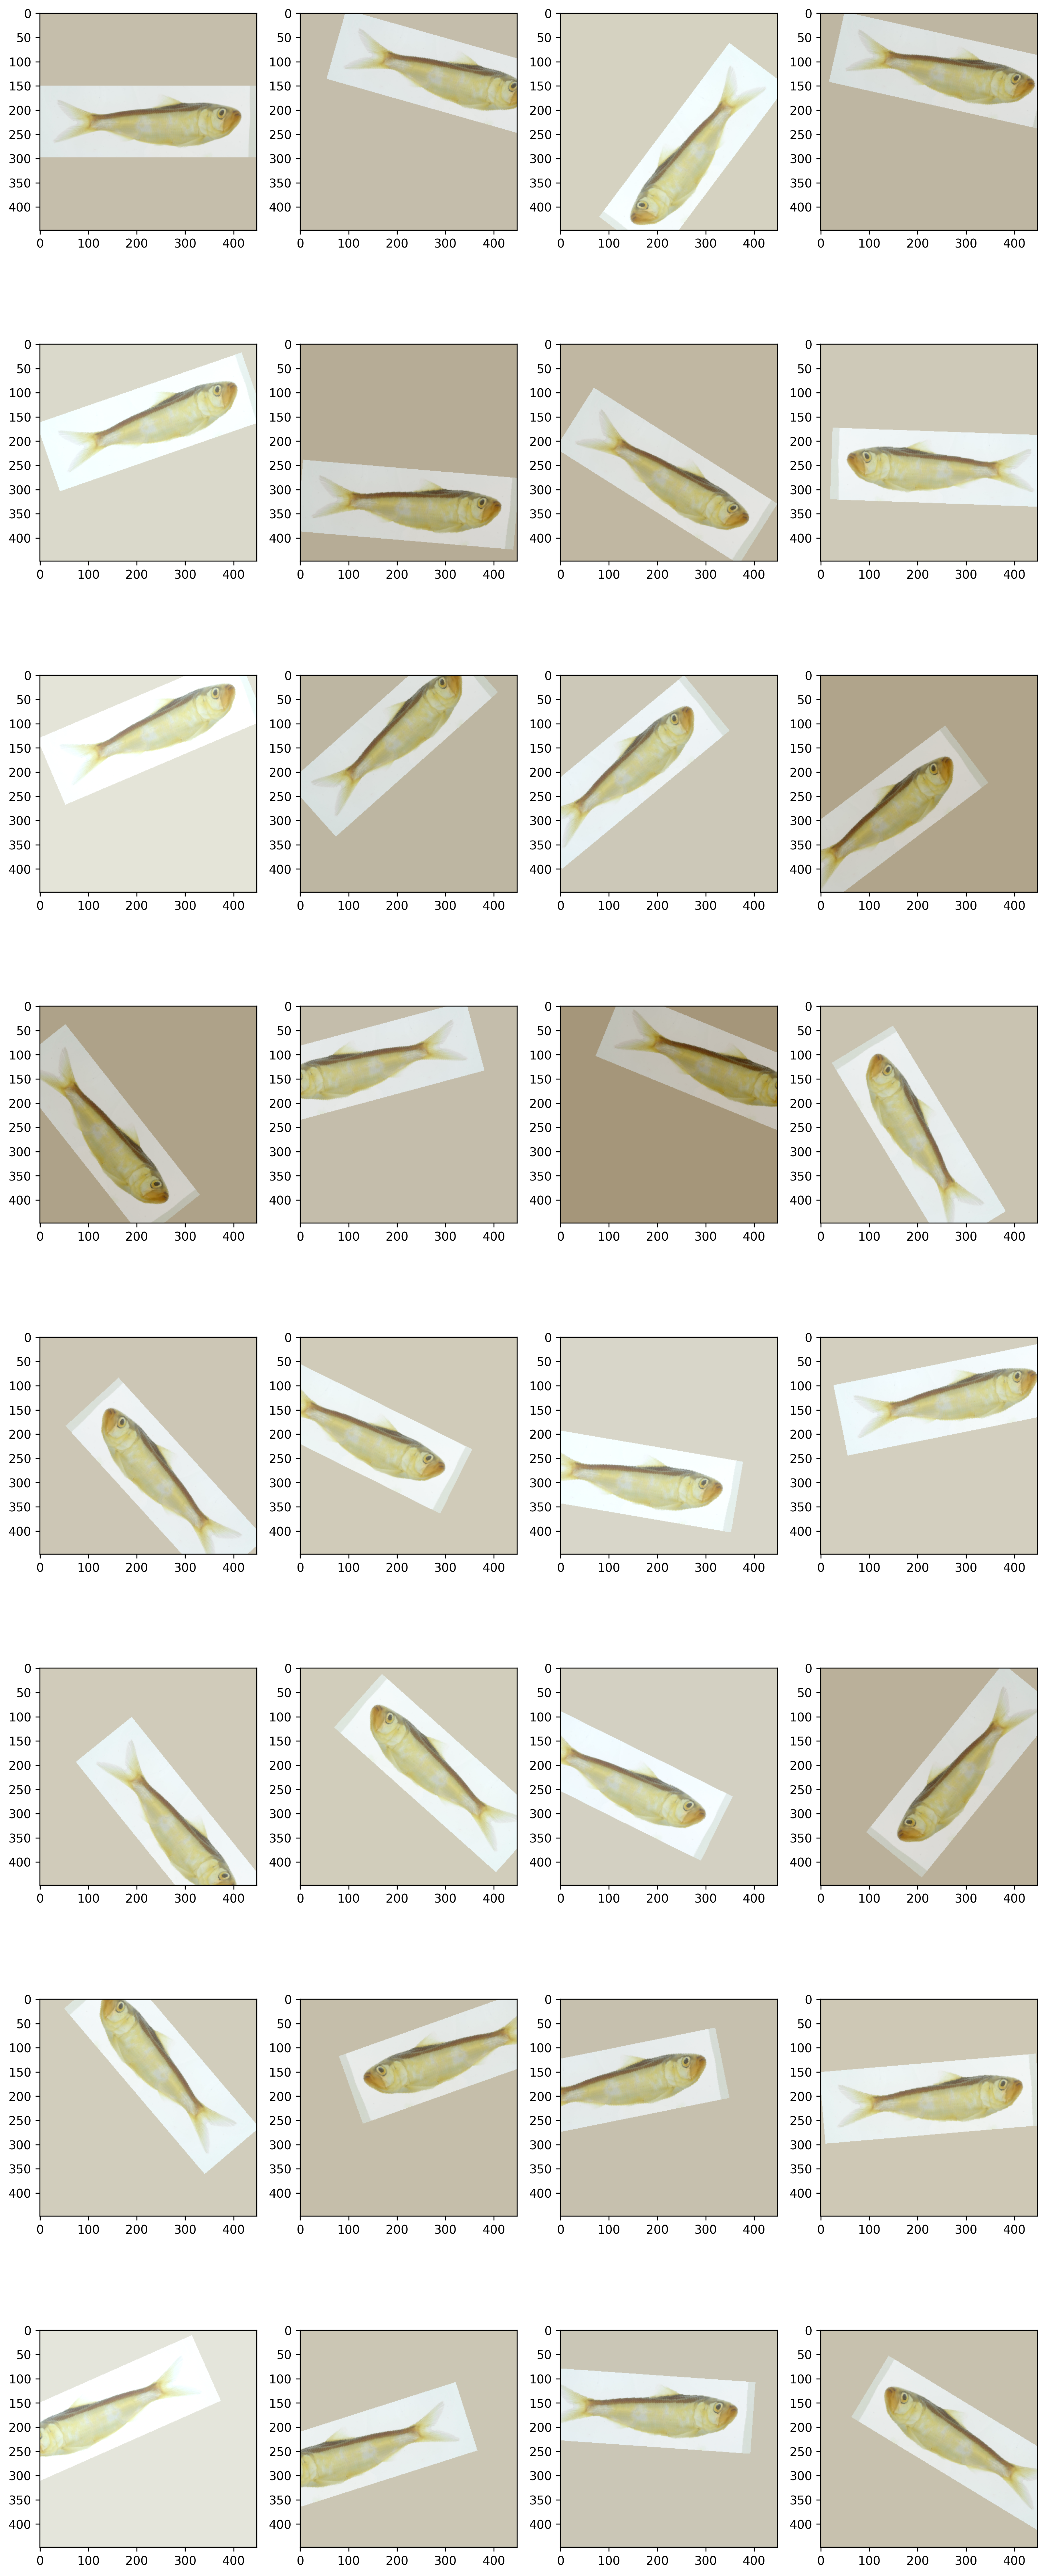

In [8]:
print('A sample. First image is not transformed')

plotSamples(dataset_train)

In [11]:
def generate_and_save_augmented_images(dataLoader, dir_name):
    with tqdm(total=len(dataLoader.dataset)) as bar:
        for batch in dataLoader:
            original = batch['image'].squeeze()
            fileName = batch['fileName'][0]
            fine = batch['fine'][0]
            prefix, ext = os.path.splitext(fileName)

            # Generate a scaled version
            suffix = experiment_params["suffix"]+"_"+str(experiment_params["img_res"])
            full_path = os.path.join(dataPath, experiment_params["image_path"], suffix, dir_name, dataLoader.dataset.csv_processor.getFineList()[fine])
            os.makedirs(full_path, exist_ok=True)
            savedFileName = os.path.join(full_path, prefix+"_"+str(imageDimension)+"_aug_0"+ext)
            scaled = transforms.ToPILImage()(original)
            scaled.save(savedFileName)
    #         print(savedFileName, "saved!")

            # Generate augmented versions
            for j in range(numOfAugmentedVersions):
                image = transforms.ToPILImage()(original)
                image = transform(image, dataLoader.dataset.RGBmean, dataLoader.dataset.color_pca)


                savedFileName = os.path.join(full_path, prefix+"_"+str(imageDimension)+"_aug_"+str(j+1)+ext)
                image.save(savedFileName)
    #             print(savedFileName, "saved!")

            bar.update()

    
    

In [12]:
generate_and_save_augmented_images(getLoader(dataset_train), "train")

In [13]:
generate_and_save_augmented_images(getLoader(dataset_val), "val")

In [14]:
generate_and_save_augmented_images(getLoader(dataset_test), "test")

Copy metadata file if found

In [17]:
suffix = experiment_params["suffix"]+"_"+str(experiment_params["img_res"])    
src = os.path.join(dataPath, experiment_params["image_path"], experiment_params["suffix"], "cleaned_metadata.csv")
dest = os.path.join(dataPath, experiment_params["image_path"], suffix, "cleaned_metadata.csv")
shutil.copy(src, dest)

'/data/BGNN_data/INHS_cropped/biology_paper_cleaned_50max_448/cleaned_metadata.csv'